# Log Analysis
HDFSデータセット('https://github.com/logpai/loghub/tree/master/HDFS')を利用して、ログ解析(アノマリ検知)を行う。

In [1]:
########################################### ログのフォーマットやlabelを別途確認する必要あり #######################################
# HDFS うまくできていない
# label付けがちゃんとできてない？
#以下の上のログはlabel0だが、下のログはlabel0になっている。

#dfs.DataNode$DataXceiver: 10.251.71.146:50010:Got exception while serving blk_-2032740670708110312 to /10.251.197.161:
#dfs.DataNode$DataXceiver: 10.251.67.113:50010:Got exception while serving blk_-62891505109755100 to /10.250.7.96:
###################################################################################################################################

### Import

In [2]:
import sys
import os
import pandas as pd
import datetime
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  StratifiedKFold
from sklearn.model_selection import  GridSearchCV
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

sys.path.append(os.path.join(os.path.dirname("__file__"), "./src/"))
from data_preprocessing import DataPreprocessing, FeatureExtraction, CreateLabel_Apache, RelatedInfo

### Config

In [3]:
class Config:
    resource_name = "HDFS"
    log_data_path = "./data/" + resource_name + "/" + resource_name + "_2k.log"
    feedback_ratio = 0.3
    train_size = 0.8
    th = 0.75
    n_splits = 5
config = Config

### Get Data

In [4]:
with open(config.log_data_path, "r") as f:
    log_data = pd.DataFrame({"log": f.readlines()})
anomaly_label_data = pd.read_csv("./data/HDFS/HDFS.anomaly_label.csv")
display(log_data)
display(anomaly_label_data)

,log
0,081109 203615 148 INFO dfs.DataNode$PacketResp...
1,081109 203807 222 INFO dfs.DataNode$PacketResp...
2,081109 204005 35 INFO dfs.FSNamesystem: BLOCK*...
3,081109 204015 308 INFO dfs.DataNode$PacketResp...
4,081109 204106 329 INFO dfs.DataNode$PacketResp...
...,...
1995,081111 101621 24902 INFO dfs.DataNode$DataXcei...
1996,081111 101735 26595 INFO dfs.DataNode$PacketRe...
1997,081111 101804 26494 INFO dfs.DataNode$DataXcei...
1998,081111 101954 26414 INFO dfs.DataNode$PacketRe...


,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal
2,blk_-3544583377289625738,Anomaly
3,blk_-9073992586687739851,Normal
4,blk_7854771516489510256,Normal
...,...,...
575056,blk_1019720114020043203,Normal
575057,blk_-2683116845478050414,Normal
575058,blk_5595059397348477632,Normal
575059,blk_1513937873877967730,Normal


### Data Preprocessing

In [5]:
log_data_list = []
for i in range(log_data.shape[0]):
    L = str(log_data.values[i][0]).split()
    message_time = "20" + L[0] + " " + L[1]
    message_time = datetime.datetime.strptime(message_time, '%Y%m%d %H%M%S')
    message = " ".join(L[4:])
    blk_id = [x for x in L if "blk_" in x][0]
    log_data_list.append([message_time,  message, blk_id])
data = pd.DataFrame(log_data_list, columns=["message_time", "message", "blk_id"])
# label付与
data = pd.merge(data, anomaly_label_data,   left_on="blk_id", right_on="BlockId")
# label変換
label_dict = {"Normal":0, "Anomaly": 1}
data["label"] = data["Label"].map(label_dict)
data = data[["message_time", "message", "label", "blk_id"]]
display(data)

,message_time,message,label,blk_id
0,2008-11-09 20:36:15,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_38865049064139660
1,2008-11-09 20:38:07,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_-6952295868487656571
2,2008-11-09 20:40:05,dfs.FSNamesystem: BLOCK* NameSystem.addStoredB...,0,blk_7128370237687728475
3,2008-11-09 20:40:15,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_8229193803249955061
4,2008-11-09 20:41:06,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_-6670958622368987959
...,...,...,...,...
1995,2008-11-11 10:16:21,dfs.DataNode$DataXceiver: Receiving block blk_...,0,blk_4198733391373026104
1996,2008-11-11 10:17:35,dfs.DataNode$PacketResponder: Received block b...,0,blk_-5815145248455404269
1997,2008-11-11 10:18:04,dfs.DataNode$DataXceiver: Receiving block blk_...,0,blk_-295306975763175640
1998,2008-11-11 10:19:54,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_5225719677049010638


### EDA

In [6]:
data_info = data.groupby(["blk_id"]).size()
display(pd.DataFrame(data_info,columns=["件数"]).sort_values("件数", ascending=False).head(10))
data_info = data.groupby(["label"]).size()
display(pd.DataFrame(data_info,columns=["件数"]))

,件数
blk_id,
blk_8596624696139957935,2
blk_-8775602795571523802,2
blk_6400082566804273401,2
blk_-4411589101766563890,2
blk_707166530951154301,2
blk_-7029628814943626474,2
blk_3849239820458663566,1
blk_3852281952649038166,1
blk_3858015337960682724,1


,件数
label,
0,1931
1,69


### Split Data

In [7]:
# 正常/異常データの分割
normal_data = data[data["label"]==0].reset_index(drop=True)
anomaly_data = data[data["label"]==1].reset_index(drop=True)
# feedbackデータと異常データの分割(feedbackのlabelは-1とする)
extract_index = random.sample(range(anomaly_data.shape[0]), k=int(anomaly_data.shape[0] * config.feedback_ratio))
feedback = anomaly_data.iloc[extract_index,:].reset_index(drop=True)
feedback["label"] = -1
anomaly_data = anomaly_data.drop(extract_index).reset_index(drop=True)
# 学習/推論データに分割
data_tmp = pd.concat([normal_data, anomaly_data])
train, test = train_test_split(data_tmp, train_size=config.train_size, shuffle=True, random_state=1)
train = train.sort_values("message_time").reset_index(drop=True)
test = test.sort_values("message_time").reset_index(drop=True)
# 表示
display(train.head())
display(test.head())
display(feedback.head())

,message_time,message,label,blk_id
0,2008-11-09 20:38:07,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_-6952295868487656571
1,2008-11-09 20:40:05,dfs.FSNamesystem: BLOCK* NameSystem.addStoredB...,0,blk_7128370237687728475
2,2008-11-09 20:41:06,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_-6670958622368987959
3,2008-11-09 20:41:32,dfs.FSNamesystem: BLOCK* NameSystem.addStoredB...,0,blk_3050920587428079149
4,2008-11-09 20:43:24,dfs.FSNamesystem: BLOCK* NameSystem.addStoredB...,0,blk_7888946331804732825


,message_time,message,label,blk_id
0,2008-11-09 20:36:15,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_38865049064139660
1,2008-11-09 20:40:15,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_8229193803249955061
2,2008-11-09 20:45:25,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_572492839287299681
3,2008-11-09 20:48:15,dfs.DataNode$DataXceiver: Receiving block blk_...,0,blk_5792489080791696128
4,2008-11-09 20:51:57,dfs.DataNode$PacketResponder: Received block b...,0,blk_9212264480425680329


,message_time,message,label,blk_id
0,2008-11-10 10:32:01,dfs.FSDataset: Deleting block blk_848384847325...,-1,blk_8483848473254499625
1,2008-11-10 21:01:53,dfs.FSNamesystem: BLOCK* NameSystem.delete: bl...,-1,blk_1102735311308675356
2,2008-11-09 22:05:28,dfs.DataNode$DataXceiver: 10.251.203.166:50010...,-1,blk_8787656642683881295
3,2008-11-11 08:14:06,dfs.FSDataset: Deleting block blk_-76064670015...,-1,blk_-7606467001548719462
4,2008-11-10 01:35:37,dfs.DataNode$DataXceiver: Receiving block blk_...,-1,blk_-6486714614940767660


### remove parameter

In [8]:
feedback["message_after"] = DataPreprocessing(feedback["message"].values)()
train["message_after"] = DataPreprocessing(train["message"].values)()
test["message_after"] = DataPreprocessing(test["message"].values)()
display(train.head())
display(test.head())
display(feedback.head())

,message_time,message,label,blk_id,message_after
0,2008-11-09 20:38:07,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_-6952295868487656571,dfs PacketResponder for block terminating
1,2008-11-09 20:40:05,dfs.FSNamesystem: BLOCK* NameSystem.addStoredB...,0,blk_7128370237687728475,dfs FSNamesystem NameSystem addStoredBlock blo...
2,2008-11-09 20:41:06,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_-6670958622368987959,dfs PacketResponder for block terminating
3,2008-11-09 20:41:32,dfs.FSNamesystem: BLOCK* NameSystem.addStoredB...,0,blk_3050920587428079149,dfs FSNamesystem NameSystem addStoredBlock blo...
4,2008-11-09 20:43:24,dfs.FSNamesystem: BLOCK* NameSystem.addStoredB...,0,blk_7888946331804732825,dfs FSNamesystem NameSystem addStoredBlock blo...


,message_time,message,label,blk_id,message_after
0,2008-11-09 20:36:15,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_38865049064139660,dfs PacketResponder for block terminating
1,2008-11-09 20:40:15,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_8229193803249955061,dfs PacketResponder for block terminating
2,2008-11-09 20:45:25,dfs.DataNode$PacketResponder: PacketResponder ...,0,blk_572492839287299681,dfs PacketResponder for block terminating
3,2008-11-09 20:48:15,dfs.DataNode$DataXceiver: Receiving block blk_...,0,blk_5792489080791696128,dfs Receiving block src dest
4,2008-11-09 20:51:57,dfs.DataNode$PacketResponder: Received block b...,0,blk_9212264480425680329,dfs Received block of size from


,message_time,message,label,blk_id,message_after
0,2008-11-10 10:32:01,dfs.FSDataset: Deleting block blk_848384847325...,-1,blk_8483848473254499625,dfs FSDataset Deleting block file mnt hadoop d...
1,2008-11-10 21:01:53,dfs.FSNamesystem: BLOCK* NameSystem.delete: bl...,-1,blk_1102735311308675356,dfs FSNamesystem NameSystem delete is added to...
2,2008-11-09 22:05:28,dfs.DataNode$DataXceiver: 10.251.203.166:50010...,-1,blk_8787656642683881295,dfs Served block to
3,2008-11-11 08:14:06,dfs.FSDataset: Deleting block blk_-76064670015...,-1,blk_-7606467001548719462,dfs FSDataset Deleting block file mnt hadoop d...
4,2008-11-10 01:35:37,dfs.DataNode$DataXceiver: Receiving block blk_...,-1,blk_-6486714614940767660,dfs Receiving block src dest


### feature extraction

In [9]:
train_all = pd.concat([train, feedback]).reset_index(drop=True)
train_feature, vocabulary = FeatureExtraction(train_all["message_after"].values, mode="train", fe_type="tfilf")()
test_feature, _ = FeatureExtraction(test["message_after"].values, mode="test", fe_type="tfilf")()
train_feature = pd.concat([train_feature, train_all["label"]], axis=1)
test_feature = pd.concat([test_feature, test["label"]], axis=1)
display(train_feature.head())
display(test_feature.head())

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,label
0,6.682121,7.370305,6.682121,6.682121,7.370305,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,6.682121,0.000000,0.000000,0.000000,0.000000,7.370305,7.370305,7.370305,7.370305,7.370305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,6.682121,7.370305,6.682121,6.682121,7.370305,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,6.682121,0.000000,0.000000,0.000000,0.000000,7.370305,7.370305,7.370305,7.370305,7.370305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,6.682121,0.000000,0.000000,0.000000,0.000000,7.370305,7.370305,7.370305,7.370305,7.370305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,label
0,5.283279,5.971464,5.283279,5.283279,5.971464,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,5.283279,5.971464,5.283279,5.283279,5.971464,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,5.283279,5.971464,5.283279,5.283279,5.971464,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,5.283279,0.000000,0.000000,5.283279,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,5.283279,0.000000,0.000000,5.283279,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Create Label
trainデータのlabelをfeedbackデータ(label=-1のデータ)を基にコサイン類似度から生成する。

In [10]:
train_feature = CreateLabel_Apache(train_all, train_feature, config.th)()
display(train_feature.head(10))

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,label,category,category_pred,related,use_label
0,6.682121,7.370305,6.682121,6.682121,7.370305,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,dfs PacketResponder for block terminating,dfs PacketResponder for block terminating,1.0,1
1,6.682121,0.000000,0.000000,0.000000,0.000000,7.370305,7.370305,7.370305,7.370305,7.370305,...,0.0,0.0,0.0,0.0,0.0,0,dfs FSNamesystem NameSystem addStoredBlock blo...,dfs FSNamesystem NameSystem addStoredBlock blo...,1.0,1
2,6.682121,7.370305,6.682121,6.682121,7.370305,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,dfs PacketResponder for block terminating,dfs PacketResponder for block terminating,1.0,1
3,6.682121,0.000000,0.000000,0.000000,0.000000,7.370305,7.370305,7.370305,7.370305,7.370305,...,0.0,0.0,0.0,0.0,0.0,0,dfs FSNamesystem NameSystem addStoredBlock blo...,dfs FSNamesystem NameSystem addStoredBlock blo...,1.0,1
4,6.682121,0.000000,0.000000,0.000000,0.000000,7.370305,7.370305,7.370305,7.370305,7.370305,...,0.0,0.0,0.0,0.0,0.0,0,dfs FSNamesystem NameSystem addStoredBlock blo...,dfs FSNamesystem NameSystem addStoredBlock blo...,1.0,1
5,6.682121,0.000000,0.000000,0.000000,0.000000,7.370305,7.370305,7.370305,7.370305,7.370305,...,0.0,0.0,0.0,0.0,0.0,0,dfs FSNamesystem NameSystem addStoredBlock blo...,dfs FSNamesystem NameSystem addStoredBlock blo...,1.0,1
6,6.682121,0.000000,0.000000,6.682121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,dfs Received block of size from,dfs Received block of size from,1.0,1
7,6.682121,0.000000,0.000000,6.682121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,dfs Received block of size from,dfs Received block of size from,1.0,1
8,6.682121,0.000000,0.000000,6.682121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,dfs Receiving block src dest,dfs Receiving block src dest,1.0,1
9,6.682121,0.000000,0.000000,0.000000,0.000000,7.370305,7.370305,7.370305,7.370305,7.370305,...,0.0,0.0,0.0,0.0,0.0,0,dfs FSNamesystem NameSystem addStoredBlock blo...,dfs FSNamesystem NameSystem addStoredBlock blo...,1.0,1


### Train

In [11]:
params = {"max_length": [5,8,10]}
clf = GridSearchCV(lgb.LGBMClassifier(verbose=-1), params, cv=StratifiedKFold(n_splits=config.n_splits), scoring="recall_macro")
model = clf.fit(train_feature.iloc[:,:-5].values, train_feature["use_label"].values) # TF-ILFで特徴量抽出したデータでモデル生成

[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length
[LightGBM] [Warning] Unknown parameter: max_length


### Top10 Keyword

In [12]:
keyword = pd.DataFrame({"word": vocabulary.keys(), "importance":model.best_estimator_.feature_importances_})
keyword = keyword.sort_values("importance", ascending=False)
display(keyword.head(10))

,word,importance
3,block,97
1,PacketResponder,89
6,NameSystem,88
15,of,75
5,FSNamesystem,74
2,for,70
42,delete,15
7,addStoredBlock,14
0,dfs,12
12,to,12


### Train Score
本来の異常とのスコアを算出

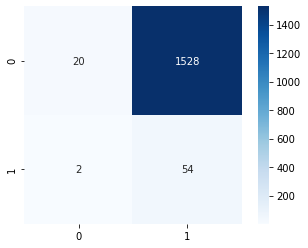

,precision,recall,f1-score,support
0,0.909091,0.012920,0.025478,1548.000000
1,0.034134,0.964286,0.065934,56.000000
accuracy,0.046135,0.046135,0.046135,0.046135
macro avg,0.471612,0.488603,0.045706,1604.000000
weighted avg,0.878544,0.046135,0.026890,1604.000000


In [13]:
y_true = train_feature["label"].apply(lambda x : 1 if x == -1 else x).values
y_pred = model.predict(train_feature.iloc[:,:-5].values)
# scoring
cm = confusion_matrix(y_true, y_pred)
classification_result = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
# display
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
display(classification_result)

### Test

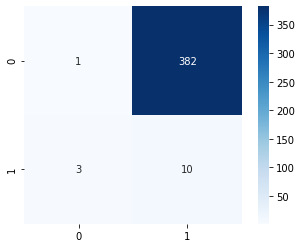

,precision,recall,f1-score,support
0,0.250000,0.002611,0.005168,383.000000
1,0.025510,0.769231,0.049383,13.000000
accuracy,0.027778,0.027778,0.027778,0.027778
macro avg,0.137755,0.385921,0.027275,396.000000
weighted avg,0.242630,0.027778,0.006619,396.000000


In [14]:
test_feature["y_pred"] = model.predict(test_feature.iloc[:,:-1].values)
# scoring
cm = confusion_matrix(test_feature["label"], test_feature["y_pred"])
classification_result = pd.DataFrame(classification_report(test_feature["label"], test_feature["y_pred"], output_dict=True)).T
# display
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')
plt.show()
display(classification_result)

### Visualize Log

In [15]:
all_proba = RelatedInfo(test_feature, train_feature)()
result = pd.concat([test[["message_time", "message","label"]], all_proba], axis=1)
result = result.rename(columns={"label":"【参考】本来のlabel"})
result = result[["message_time", "message", "正常(0)/異常(1)", "関連する過去の障害", "関連度(%)", "【参考】本来のlabel"]]

In [16]:
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: red' if is_max.any() else '' for v in is_max]
result.style.apply(highlight_greaterthan, threshold=1.0, column=['正常(0)/異常(1)'], axis=1)

,message_time,message,正常(0)/異常(1),関連する過去の障害,関連度(%),【参考】本来のlabel
0,2008-11-09 20:36:15,dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_38865049064139660 terminating,1,dfs PacketResponder for block terminating,100.0,0
1,2008-11-09 20:40:15,dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_8229193803249955061 terminating,1,dfs PacketResponder for block terminating,100.0,0
2,2008-11-09 20:45:25,dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_572492839287299681 terminating,1,dfs PacketResponder for block terminating,100.0,0
3,2008-11-09 20:48:15,dfs.DataNode$DataXceiver: Receiving block blk_5792489080791696128 src: /10.251.30.6:33145 dest: /10.251.30.6:50010,1,dfs Receiving block src dest,100.0,0
4,2008-11-09 20:51:57,dfs.DataNode$PacketResponder: Received block blk_9212264480425680329 of size 67108864 from /10.251.123.1,1,dfs Received block of size from,100.0,0
5,2008-11-09 21:00:37,dfs.DataNode$DataXceiver: Receiving block blk_-5009020203888190378 src: /10.251.199.19:52622 dest: /10.251.199.19:50010,1,dfs Receiving block src dest,100.0,0
6,2008-11-09 21:07:12,dfs.DataNode$PacketResponder: Received block blk_-8523968015014407246 of size 67108864 from /10.251.214.225,1,dfs Received block of size from,100.0,0
7,2008-11-09 21:13:53,dfs.DataNode$PacketResponder: PacketResponder 0 for block blk_7791237942696729620 terminating,1,dfs PacketResponder for block terminating,100.0,0
8,2008-11-09 21:14:03,dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.202.134:50010 is added to blk_2113880130496815041 size 3549917,1,dfs FSNamesystem NameSystem addStoredBlock blockMap updated is added to size,99.9,0
9,2008-11-09 21:14:53,dfs.DataNode$PacketResponder: Received block blk_1064470652608359218 of size 67108864 from /10.251.39.242,1,dfs Received block of size from,100.0,0
